In [71]:
import pandas as pd
from py_files import data_manager
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization
from pgmpy.inference import VariableElimination
from matplotlib import pyplot as plt

In [150]:
# load in feather file
final_df = pd.read_feather('data/play_by_play_full_state_space.feather')
final_df['WIN'] = final_df['home_score'] > final_df['away_score']
final_df = final_df[final_df['game_date'] >= '2018-10-01']
final_df = final_df[final_df['game_date'] < '2019-10-01']

In [156]:
final_df = pd.read_hdf('data/processed_data.h5', key='df')
final_df = final_df.rename(columns={'GAME_ID': 'game_id', 'HOME_GOAL':'STATE_GOAL_HOME', 'AWAY_GOAL':'STATE_GOAL_AWAY','HOME_SHOT':'STATE_SHOT_HOME', 'AWAY_SHOT':'STATE_SHOT_AWAY',
                                    'HOME_BLOCKED_SHOT':'STATE_BLOCKED_SHOT_HOME', 'AWAY_BLOCKED_SHOT':'STATE_BLOCKED_SHOT_AWAY', 'HOME_MISSED_SHOT':'STATE_MISSED_SHOT_HOME','TIME_REMAINING':'game_seconds_remaining'})


In [157]:
# take the last two season
df = final_df.copy()

label_column = 'WIN'

game_groups = df.groupby('game_id')

game_ids = df.game_id.unique()

train_ids, test_ids = train_test_split(game_ids, test_size=0.2, random_state=42)

train = df[df.game_id.isin(train_ids)]
test = df[df.game_id.isin(test_ids)]

keepers = [
    "game_id",
    "STATE_GOAL_HOME",
    "STATE_GOAL_AWAY",
    "STATE_SHOT_HOME",
    "STATE_SHOT_AWAY",
    "STATE_BLOCKED_SHOT_HOME",
    "STATE_BLOCKED_SHOT_AWAY",
    "game_seconds_remaining",
    "WIN",
]

train = train[keepers]
test = test[keepers]

model_dict = [('STATE_GOAL_HOME', 'WIN'), ('STATE_GOAL_AWAY', 'WIN')]
model_dict.extend([('game_seconds_remaining', 'STATE_SHOT_HOME'), ('game_seconds_remaining', 'STATE_SHOT_AWAY')])
model_dict.extend([('STATE_SHOT_HOME', 'STATE_GOAL_HOME'), ('STATE_SHOT_AWAY', 'STATE_GOAL_AWAY')])
model_dict.extend([('STATE_BLOCKED_SHOT_HOME', 'STATE_GOAL_AWAY'), ('STATE_BLOCKED_SHOT_AWAY', 'STATE_GOAL_HOME')])
model_dict.extend([('STATE_SHOT_HOME', 'STATE_BLOCKED_SHOT_AWAY'), ('STATE_SHOT_AWAY', 'STATE_BLOCKED_SHOT_HOME')])

# Define the structure of the Bayesian network
model = BayesianNetwork(model_dict)

# Learn the parameters of the Bayesian network using Maximum Likelihood Estimation
model.fit(train, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/257 [00:00<?, ?it/s]

100%|██████████| 257/257 [00:02<00:00, 105.04it/s]


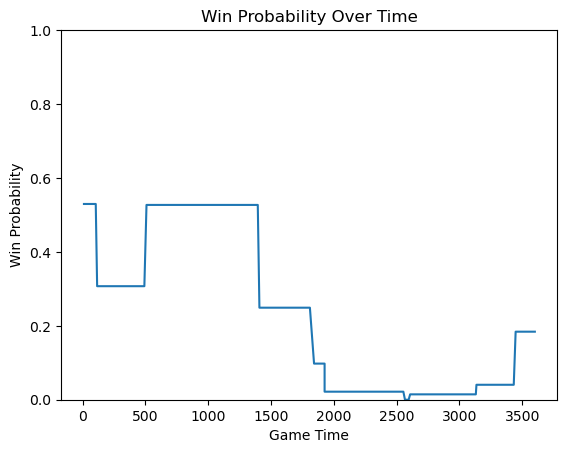

Final State
Home Score: 4
Away Score: 5


In [158]:
# pick a random game to train on from test
game_id = np.random.choice(test.game_id.unique())

game_to_test = test[test.game_id == game_id]
prob_array = np.zeros((len(game_to_test), 2))

# reset index 
game_to_test = game_to_test.reset_index(drop=True)
time_remaining = []

# loop through game to test
for index, row in tqdm(game_to_test.iterrows(), total=len(game_to_test)):
    # get the row
    row = row.to_frame().T

    # get the game state
    game_state = row[keepers]

    # get the game state
    game_state = game_state.drop(columns=['game_id', 'WIN'])
    time_remaining.append(row['game_seconds_remaining'])

    inference = VariableElimination(model)

    # Define the evidence
    evidence = game_state.to_dict(orient='records')[0]

    # Perform inference to compute posterior probabilities
    posterior_probabilities = inference.query(variables=['WIN'], evidence=evidence)

    # Extract probabilities of each outcome
    home_team_win_probability = posterior_probabilities.values[1]

    # add the win probability to the array
    prob_array[index, :] = home_team_win_probability

# plot the win probability
plt.ylim(0, 1)
plt.plot(time_remaining[::-1], prob_array[:, 1])
plt.xlabel('Game Time')
plt.ylabel('Win Probability')
plt.title('Win Probability Over Time')
plt.show()

# print final state
print('Final State')
print('Home Score:', game_state['STATE_GOAL_HOME'].values[0])
print('Away Score:', game_state['STATE_GOAL_AWAY'].values[0])

In [132]:
good_game_ids = []

In [135]:
good_game_ids.append(game_id)

In [108]:
inference = VariableElimination(model)

# Define the evidence
# evidence = game_state.to_dict(orient='records')[0]
evidence = {}
evidence['STATE_GOAL_HOME'] = 4
evidence['STATE_GOAL_AWAY'] = 4

# Perform inference to compute posterior probabilities
posterior_probabilities = inference.query(variables=['WIN'], evidence=evidence)

# Extract probabilities of each outcome
home_team_win_probability = posterior_probabilities.values[1]
away_team_win_probability = posterior_probabilities.values[0]

print("Probability of Home Team Win:", home_team_win_probability)
print("Probability of Away Team Win:", away_team_win_probability)

Probability of Home Team Win: 0.46687054026503566
Probability of Away Team Win: 0.5331294597349643
